In [1]:
import torch
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt

/Users/pranitgunjal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [37]:
sentence_transformer = SentenceTransformer('all-mpnet-base-v2')

- Add Train-Test Split
- Use privacy protection (keyword extraction based generations)
- 2 Player Simulated Data
- Game Events Simulation

In [38]:
def MMD(X, Y, kernel="rbf", device=None):
    """
    Compute the empirical Maximum Mean Discrepancy (MMD) between two samples X and Y.

    Args:
        X (torch.Tensor): Samples from distribution P, shape (n, m)
        Y (torch.Tensor): Samples from distribution Q, shape (l, m)
        kernel (str): Kernel type, "rbf" or "multiscale"
        device (torch.device or None): Device to run on (e.g., torch.device("cuda"))
    
    Returns:
        torch.Tensor: Scalar MMD distance between the two distributions.
    """
    if device is None:
        device = X.device

    X = X.to(device)
    Y = Y.to(device)

    n = X.size(0)
    l = Y.size(0)

    # Compute squared Euclidean distances
    XX_dist = torch.cdist(X, X, p=2).pow(2)  # (n, n)
    YY_dist = torch.cdist(Y, Y, p=2).pow(2)  # (l, l)
    XY_dist = torch.cdist(X, Y, p=2).pow(2)  # (n, l)

    # Initialize kernels
    if kernel == "rbf":
        bandwidths = [10, 15, 20, 50]
        def compute_kernel(dists):
            K = 0
            for a in bandwidths:
                K += torch.exp(-0.5 * dists / a)
            return K

    elif kernel == "multiscale":
        bandwidths = [0.2, 0.5, 0.9, 1.3]
        def compute_kernel(dists):
            K = 0
            for a in bandwidths:
                K += (a**2) / (a**2 + dists)
            return K

    else:
        raise ValueError("Unknown kernel. Use 'rbf' or 'multiscale'.")

    # Apply kernel
    K_xx = compute_kernel(XX_dist)
    K_yy = compute_kernel(YY_dist)
    K_xy = compute_kernel(XY_dist)

    # MMD estimate
    mmd = K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()
    return mmd


In [108]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def MMD(x, y, kernel):
#     """Emprical maximum mean discrepancy. The lower the result
#        the more evidence that distributions are the same.

#     Args:
#         x: first sample, distribution P
#         y: second sample, distribution Q
#         kernel: kernel type such as "multiscale" or "rbf"
#     """
#     xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
#     rx = (x.pow(2).sum(1)).unsqueeze(1)  
#     ry = (y.pow(2).sum(1)).unsqueeze(0)  

#     dxx = rx + rx.t() - 2 * torch.mm(x, x.t())   
#     dyy = ry.t() + ry - 2 * torch.mm(y, y.t())  
#     dxy = rx + ry - 2 * torch.mm(x, y.t())       
    
#     XX, YY, XY = (torch.zeros_like(dxx).to(device),
#                   torch.zeros_like(dyy).to(device),
#                   torch.zeros_like(dxy).to(device))
    
#     if kernel == "multiscale":
        
#         bandwidth_range = [0.2, 0.5, 0.9, 1.3]
#         for a in bandwidth_range:
#             XX += a**2 * (a**2 + dxx)**-1
#             YY += a**2 * (a**2 + dyy)**-1
#             XY += a**2 * (a**2 + dxy)**-1
            
#     if kernel == "rbf":
      
#         bandwidth_range = [10, 15, 20, 50]
#         for a in bandwidth_range:
#             XX += torch.exp(-0.5*dxx/a)
#             YY += torch.exp(-0.5*dyy/a)
#             XY += torch.exp(-0.5*dxy/a)
      
      

#     return torch.mean(XX + YY - 2. * XY)

In [2]:
df = pd.read_csv('../CODsurf/cmb_prosocial_labeled.csv')
player_chats = df['player_chat']
df

,match_id,player_name,player_chat,action
0,22398,JCamz,nice lighting bolt zeus. report all of you. cl...,NOT-PROSOCIAL
1,26872,zua halucynka.,ty,PROSOCIAL
2,24083,cnywad,ggwp,PROSOCIAL
3,47512,StartWithA.BANG,LOL . Ez,NOT-PROSOCIAL
4,22039,Sol'ka,sry. ggwp,PROSOCIAL
...,...,...,...,...
4995,18647,Phantasm,yea. line problem?. valve?. fuck this,NOT-PROSOCIAL
4996,37574,1of3,gl hf. I'm not exe still nice to meet you. gg wp,PROSOCIAL
4997,28742,PookieMarkCow,pls respond. in any kind. including insult. cr...,UNCLEAR
4998,28276,Madara,np. FF. afk,NOT-PROSOCIAL


In [25]:
print("\n\n".join(df['player_chat'].sample(n=5).to_list()))

(). afk. nesite. naxui. yasno. afk. idi naxui. kuda vi po 1 . eblani]\. gem u invoka. gem. u voka. da nesite uje. zaebali. no def. zaebalo. defatb. mid fastom

+5

GG. bobo miri

look at my team. all 0 kills. so rubbish sia. ikr

solo farm top


# **Getting Distribution of Chat Lengths**

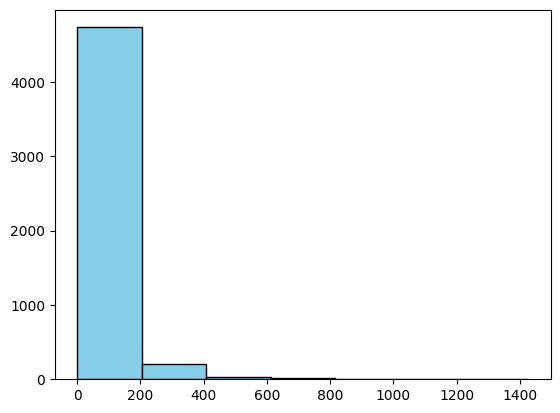

In [40]:
chat_lengths = df['player_chat'].str.len()
plt.hist(chat_lengths, bins=7, color='skyblue', edgecolor='black')
plt.show()

In [111]:
player_chats

0       nice lighting bolt zeus. report all of you. cl...
1                                                      ty
2                                                    ggwp
3                                                LOL . Ez
4                                               sry. ggwp
                              ...                        
4995                yea. line problem?. valve?. fuck this
4996     gl hf. I'm not exe still nice to meet you. gg wp
4997    pls respond. in any kind. including insult. cr...
4998                                          np. FF. afk
4999                                 ggwp commend my team
Name: player_chat, Length: 5000, dtype: object

In [41]:
X = sentence_transformer.encode(player_chats.tolist())
activision_data = np.array(X)

# **MMD Helper Method**
- Processes messages and computes MMD

In [42]:
def report_MMD(new_sentences, X, sentence_transformer=sentence_transformer, normalize=False):
    
    Y = sentence_transformer.encode(new_sentences)
    Y = np.array(Y)

    tensorX = torch.tensor(X)
    tensorY = torch.tensor(Y)
    rbf_mmd = MMD(tensorX, tensorY, "rbf")
    scale_mmd = MMD(tensorX, tensorY, "multiscale")

    if normalize:
        print(rbf_mmd / np.sqrt((1.0 / X.shape[0] + 1.0 / Y.shape[0])))
        print(scale_mmd / np.sqrt((1.0 / X.shape[0] + 1.0 / Y.shape[0])))
    else:
        print(rbf_mmd)
        print(scale_mmd)

# **Control Testing**
- Asking the LLM to generate what it thinks to be player chat content

In [43]:
new_sentences = ['Alright, team, we\'ve got this! Keep the pressure on and don\'t let them regroup—I\'ll hold the point for as long as I can. Stay sharp!']
more_new_sentences = [
  "Let's push the objective, we're so close to taking it! Stay on me, I'll lead the charge.",
  "Heads up, they've got a sniper on the right side. I'll try to distract them while you flank.",
  "Got your back, don't worry. If you need healing, just call out and I'll drop the medkit.",
  "Watch out, enemy ults incoming! We need to group up or we're gonna get wiped.",
  "I'm about to make a big play—everyone ready? This is our moment to turn the game around!"
]

In [44]:
report_MMD(new_sentences, activision_data, normalize=True)

tensor(0.1944)
tensor(3.0539)


In [45]:
report_MMD(more_new_sentences, activision_data, normalize=True)

tensor(0.2012)
tensor(1.8387)


# **Giving LLM Data**
- Uploading the CSV and asking it to generate something similar to the given text

In [46]:
new_sentences = ['gg wp. lol. u got juked hard. ez game. why u feed so much XD']
more_new_sentences = [
    "bruh. this pudge hook from mars. XD. gg anyway",
    "lol. reported for feeding. but nice ult tho. gg",
    "ez mid. u even trying? haha gg wp",
    "omg. we won that? insane teamfight. wp boys",
    "yo support buy wards pls. or we lose again. lmao"
]

In [47]:
report_MMD(new_sentences, activision_data, normalize=True)

tensor(0.1371)
tensor(2.8233)


In [48]:
report_MMD(more_new_sentences, activision_data, normalize=True)

tensor(0.0888)
tensor(1.4153)


# **Category Specific Results**
- Giving the LLM a sample of specific (i.e Prosocial, or Not Prosocial) data and seeing the results

In [18]:
prosocial_chats = df[df['action'] == 'PROSOCIAL']['player_chat']
not_prosocial_chats = df[df['action'] == 'NOT-PROSOCIAL']['player_chat']

In [19]:
prosocial_data = np.array(sentence_transformer.encode(prosocial_chats.tolist()))
not_prosocial_data = np.array(sentence_transformer.encode(not_prosocial_chats.tolist()))

## **Not-Prosocial**

In [20]:
new_sentences = ['lol you call that a play? uninstall pls']
more_new_sentences = [
    "bruh ur brain afk or what",
    "ez win ty for the feed",
    "report this clown asap",
    "wow nice throw, pro move lol",
    "can u not play next time thx"
]

In [32]:
report_MMD(new_sentences, not_prosocial_data, normalize=True)

tensor(0.1760)
tensor(2.9602)


In [33]:
report_MMD(more_new_sentences, not_prosocial_data, normalize=True)

tensor(0.1656)
tensor(1.6710)


## **Prosocial**

In [24]:
new_sentences = ['nice push top. wp team gg']
more_new_sentences = [
    "gg wp. that comeback was wild",
    "nice stun chain. well played",
    "wp guys. held high ground like champs",
    "gg. tough match but fun",
    "lol that bait mid was clean. wp"
]

In [34]:
report_MMD(new_sentences, prosocial_data, normalize=True)

tensor(0.1555)
tensor(3.2113)


In [35]:
report_MMD(more_new_sentences, prosocial_data, normalize=True)

tensor(0.2036)
tensor(2.6333)
